In [20]:
"""
Created on Sun Jan 5 14:05 2019

@author: Soeren Brandt
"""

# import our modules
import fra_expt

#import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

In [2]:
segmentcolors = [(.8, 0, 0), (0, .8, 0), (0, 0, .8)]
color = {"train": [0.5, 0.5, 0.5], "test": [0, 0, 0]}

chem_colors = {'pentane':(69./255, 127./255, 181./255), 'hexane':(238./255, 124./255, 48./255), 'octane':(192./255, 46./255, 38./255)}

labelsize = 13
ticksize = 12
legendsize = 12

#### Functions

In [3]:
from plot_functions import get_colors, plot_deriv, get_gradient_colors, get_markers
import colorsys

def plot_derivs(exp_derivs, exp_lbl, c2, c1 = 'Pentane', ax = None):
    all_lbls = sorted(list(set(exp_lbl.values())))

    # averages
    if ax == None:
        fig, ax = plt.subplots()

    maximum = 0
    colorset = get_colors(4)
    #face_color = np.flip(get_gradient_colors(len(all_lbls), colorset[0], colorset[-1]), axis = 0) # unique face color for each chemical in data set
    face_color = np.flip(get_gradient_colors(len(all_lbls), chem_colors[c1.lower()], chem_colors[c2.lower()]), axis = 0)
    markers = get_markers(len(all_lbls))
    for n, lbl in enumerate(all_lbls):
        if lbl not in [0.2, 0.4, 0.6, 0.8] + [0.25, 0.33, 0.67, 0.75]:
            # get phase derivatives
            nums = [key for key in exp_lbl.keys() if exp_lbl[key] == lbl]
            phase_derivs = [exp_derivs[num] for num in nums] #[exp_derivs[num]/np.sqrt(np.sum(exp_derivs[num]**2)) for num in nums]

            # calculate average
            avg = np.average(phase_derivs, axis = 0)

            maximum = np.max([maximum, np.max(avg)])
            #plot_deriv(avg, labels = lbl, norm = True, ax = ax, color = face_color[n], marker='s',markevery=50);

            #phase_deriv = phase_deriv/np.sqrt(np.sum(phase_deriv**2))
            if lbl == int(lbl):
                if lbl == 0:
                    ax.plot(avg, label = c2, color = face_color[n], linewidth=2.5)
                else:
                    ax.plot(avg, label = c1, color = face_color[n], linewidth=2.5)
            else:
                ax.plot(avg, label = str(lbl*100) + "%", color = face_color[n])#, marker=markers[n], markevery=int(0.03*len(avg)))

    # Clean up plot
    ax.set_xlim((0,600))
    ax.set_ylim((0, 1.1*maximum))

    # Define image labels
    ax.set_ylabel('Phase derivative (a.u.)', fontsize=labelsize)
    ax.set_xlabel('Time (s)', fontsize=labelsize)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x',colors='black')
    ax.tick_params(axis='y',colors='black')
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)

    # Image aspect ratio
    #xext, yext = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
    #xrange = xext[1] - xext[0]
    #yrange = yext[1] - yext[0]
    #plt.gca().set_aspect(1 * abs(xrange / yrange)) # This is the line that causes the warnings about unicode

    ax.legend(loc='upper right', fontsize = legendsize, markerscale = 1)
    #plt.tight_layout()
    #plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 phase derivs.png', dpi=300)
    

#-------------------------------#
#              SVR              #
#-------------------------------#
    
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

def train_SVR(train_derivs, train_lbl, kernel='rbf', C=1e1, gamma=7.):
    SVR = svm.SVR(C=C,gamma=gamma, kernel=kernel)
    SVR.fit(train_derivs, train_lbl)
    #predicted = SVR.predict(test_derivs)
    print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
    #print("Validation accuracy: " + str(SVR.score(test_derivs, test_lbl)) + " (" + str(len(test_lbl)) + ")")
    
    return SVR
    
    
# Bagging classifier

from sklearn.model_selection import GridSearchCV
from piecewise.regressor import piecewise
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

def train_multiSVR(train_derivs, train_lbl, kernel = 'rbf', error_thresh = 0.07):
    # DATASEGMENTATION INTO REGIONS
    # perform PCA
    pca = PCA()
    train_pca = pca.fit_transform(train_derivs)

    # run segmented regression algorithm
    model = piecewise(train_lbl,train_pca[:,0],error_thresh)
    
    # get boundaries from piecewise model
    for seg in model.segments:
        concs_new = [seg.start_t, seg.inclusive_end_t]
        y_hat = [seg.predict(conc) for conc in concs_new]

    #defines boundaries of regression
    regions = []
    for y in train_lbl:
        #for n, seg in enumerate(model.segments):
        findSegment = [y <= seg.inclusive_end_t for seg in model.segments]
        regions.append(findSegment.index(True))

    #creates classifier for the categories for low-medium and high concentration ranges.
    break_clf = BaggingClassifier(n_estimators = 50, max_samples = 1.0, max_features = 10)
    break_clf.fit(train_derivs, regions)
    
    # TRAIN ONE SVR PER REGION
    # prepare dictionary for SVR
    SVR_in = {}
    
    for region in set(regions): # changed this without checking on 5/8
        # separate training set into regions
        X = [train_derivs[n] for n,reg in enumerate(regions) if reg == region]
        Y = [train_lbl[n] for n,reg in enumerate(regions) if reg == region]
        
        # perform SVR in region
        SVR_in[region] = svm.SVR(C=1e1,gamma=0.7e1, kernel=kernel) #Ridge(alpha=alpha, fit_intercept=False)
        SVR_in[region].fit(X, Y)
        
    model = {'SVR':SVR_in, 'BC':break_clf, 'PCA':pca, 'segments':model.segments}
    print("Training accuracy: " + str(calculate_R2(train_lbl,predict_multiSVR(model, train_derivs))) + " (" + str(len(train_lbl)) + ")")
    
    return model


def predict_multiSVR(model, test_derivs):
    # prepare output of predictions
    prediction = []

    for deriv in test_derivs:
        # reshape test data to conform with predictors
        deriv = np.array(deriv).reshape(1,-1)

        # determines the concentration level based on the random forest classifier
        region = model['BC'].predict(deriv)[0] # high = break_clf.predict(deriv)
        
        # predict concentration
        prediction.append(model['SVR'][region].predict(deriv))

    return prediction


#-------------------------------#
#           Plotting            #
#-------------------------------#

def calculate_R2(actual,predicted):
    # convert to array
    actual = np.array(actual).reshape(1,-1)
    predicted = np.array(predicted).reshape(1,-1)
    
    # calculate errors
    res_ss = np.sum((predicted-actual)**2)
    total_ss = np.sum((np.mean(actual)-actual)**2)
    
    return 1-res_ss/total_ss


def plot_regression(actual, predicted, c='k', model = None, initial_colorID = 0, ax = None):
    # plots the real vs predicted concentrations
    if ax == None:
        plt.figure(figsize = (3,5))
        ax = plt.gca()
    ax.set_xlabel('Actual Pentane Concentration', fontsize = labelsize)
    ax.set_ylabel('Predicted Pentane Concentration', fontsize = labelsize)
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
    
    # plot line representing 1:1 correspondence
    ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',c='k',linewidth=1)
    
    # scatter predictions
    ax.scatter(np.array(actual),np.array(predicted),c=c,s=15)
    
    # Label performance
    score = calculate_R2(actual,predicted)
    ax.text(0.065,0.97, "$R^2$ = "+str(round(score,3)), fontsize=labelsize, verticalalignment='top', transform = ax.transAxes)
    
    # add model regions
    if model:
        for n, segment in enumerate(model['segments']):
            ax.axvspan(segment.start_t, segment.inclusive_end_t, facecolor=segmentcolors[np.mod(n+initial_colorID,len(segmentcolors))], alpha=0.1)
    
    # clean up plot
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    
def plot_segmentation(model, train_derivs, train_lbl, test_derivs, test_lbl, initial_colorID = 0, ax = None):
    # plot segmented regression results
    if ax == None:
        plt.figure(figsize = (5,5))
        ax = plt.gca()
    
    # calculate PCA
    train_pca = model['PCA'].transform(train_derivs)
    test_pca = model['PCA'].transform(test_derivs)
    
    # Plot data
    ax.plot(np.array(test_lbl),np.array(test_pca[:, 0]), '.', c=color["test"], label = "Test data")
    ax.scatter(train_lbl, train_pca[:, 0],c='None', marker='s',s=20,edgecolors=color["train"],linewidths=1, label = "Training data")
    for n, seg in enumerate(model['segments']):
        concs_new = [seg.start_t, seg.inclusive_end_t]
        y_hat = [seg.predict(conc) for conc in concs_new]
        ax.plot(concs_new, y_hat, c=np.array(segmentcolors[np.mod(n+initial_colorID,len(segmentcolors))])*0.75)
    
    ax.set_xlabel('Actual Pentane Concentration', fontsize = labelsize)
    ax.set_ylabel('Principal Component 1', fontsize = labelsize)
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)

    ax.legend(loc='upper left', fontsize = legendsize, markerscale = 1.5)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.45, 0.65])

## Pentane-Hexane

In [21]:
# Parameters
volume = [0.4] # 1.3mL (or 0.4 for C5C6?)
rate = 6.0   # 6.0mL/min
time = [4.0]   # 15.0s (or 4.0 for C5C6?)

In [22]:
from datasets import *
C5C6_set = binary_mixtures(['Pentane', 'Hexane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time(time), and_b = injection_Rate(rate), and_c = injection_Volume(volume))
#train_set, test_set = train_test_split(exp_set)
try:
    C5C6_set[1.0].remove(622)
except:
    pass

Load data

In [23]:
from data_functions import load_set_from_CSV
C5C6_derivs, C5C6_concentrations, m = load_set_from_CSV(C5C6_set)

# normalize
for num in C5C6_derivs.keys():
    C5C6_derivs[num] = C5C6_derivs[num]/np.sqrt(np.sum(C5C6_derivs[num]**2))

Loading experimental data 
0.0: [===================0] 100%   1/11 complete
0.1: [===================0] 100%   2/11 complete
0.2: [===================0] 100%   3/11 complete
0.3: [===================0] 100%   4/11 complete
0.4: [===================0] 100%   5/11 complete
0.5: [===================0] 100%   6/11 complete
0.6: [===================0] 100%   7/11 complete
0.7: [===================0] 100%   8/11 complete
0.8: [===================0] 100%   9/11 complete
0.9: [===================0] 100%   10/11 complete
1.0: [===================0] 100%   11/11 complete
Length of experimental set loaded: 31


## Pentane-Octane

In [24]:
# Parameters
volume = [1.3] # 1.3mL (or 0.4 for C5C6?)
rate = 6.0   # 6.0mL/min
time = [15.0]   # 15.0s (or 4.0 for C5C6?)

In [25]:
from datasets import *
C5C8_set = binary_mixtures(['Pentane', 'Octane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([time]), and_b = injection_Rate(rate), and_c = injection_Volume([volume]))

coop_set = range(241,246)+ range (247,248) + [208,209,283,174,203] + [216,217,273,218,219,220,230,272,274,279,233,236,434,435] + range(386,401)
for key, values in C5C8_set.items():
    for value in [num for num in values if num not in coop_set]:
        C5C8_set[key].remove(value)
        
# remove empty sets
    for key, values in C5C8_set.items():
        if not values:
            C5C8_set.pop(key)
#train_set, test_set = train_test_split(exp_set)

In [26]:
#C5C8_set[0.0].remove(208)
#C5C8_set[0.25].remove(230)
#C5C8_set[0.0].remove(283)
#C5C8_set[0.1].remove(386)
#C5C8_set[0.75].remove(217)
#C5C8_set[0.9].remove(400)

In [27]:
from data_functions import load_set_from_CSV
C5C8_derivs, C5C8_concentrations, m = load_set_from_CSV(C5C8_set)

# normalize
for num in C5C8_derivs.keys():
    C5C8_derivs[num] = C5C8_derivs[num]/np.sqrt(np.sum(C5C8_derivs[num]**2))

Loading experimental data 
0.0: [===================0] 100%   1/14 complete
0.1: [===================0] 100%   2/14 complete
0.2: [===================0] 100%   3/14 complete
0.25: [===================0] 100%   4/14 complete
0.3: [===================0] 100%   5/14 complete
0.33: [===================0] 100%   6/14 complete
0.5: [===================0] 100%   7/14 complete
0.6: [===================0] 100%   8/14 complete
0.67: [===================0] 100%   9/14 complete
0.7: [===================0] 100%   10/14 complete
0.75: [===================0] 100%   11/14 complete
0.8: [===================0] 100%   12/14 complete
0.9: [===================0] 100%   13/14 complete
1.0: [===================0] 100%   14/14 complete
Length of experimental set loaded: 37


# Create plot

In [28]:
seed = 1

from datasets import train_test_split, sort_by_set
# split Hexane dataset
C5C6_train_set, C5C6_test_set = train_test_split(C5C6_set, test_size=1/2.5, seed=seed)
C5C6_train, C5C6_train_lbl, C5C6_test, C5C6_test_lbl = sort_by_set(C5C6_derivs, C5C6_train_set, C5C6_test_set)

# split Octane dataset
C5C8_train_set, C5C8_test_set = train_test_split(C5C8_set, test_size=1/2.5, seed=seed)
C5C8_train, C5C8_train_lbl, C5C8_test, C5C8_test_lbl = sort_by_set(C5C8_derivs, C5C8_train_set, C5C8_test_set)

## split Hexane dataset
#from sklearn.model_selection import train_test_split
#C5C6_train, C5C6_test, C5C6_train_lbl, C5C6_test_lbl = train_test_split(C5C6_derivs.values(), C5C6_concentrations.values(), test_size=1/2.5, random_state=seed)
#
## split Octane dataset
#from sklearn.model_selection import train_test_split
#C5C8_train, C5C8_test, C5C8_train_lbl, C5C8_test_lbl = train_test_split(C5C8_derivs.values(), C5C8_concentrations.values(), test_size=1/2.5, random_state=seed)

Create SVR

In [12]:
SVR = {}
model = {}
kernel = 'rbf'

# train simple SVR
print 'Hexane'
SVR['C5C6'] = train_SVR(C5C6_train, C5C6_train_lbl, kernel=kernel, C=100, gamma=10)
print 'Testing accuracy: ' + str( SVR['C5C6'].score(C5C6_test, C5C6_test_lbl) )

print '\nOctane'
SVR['C5C8'] = train_SVR(C5C8_train, C5C8_train_lbl, kernel=kernel)
print 'Testing accuracy: ' + str( SVR['C5C8'].score(C5C8_test, C5C8_test_lbl) )

# train multi-region SVR
print '\nMulti SVR'
model['C5C6'] = train_multiSVR(C5C6_train, C5C6_train_lbl, kernel=kernel, error_thresh = 0.07);
model['C5C8'] = train_multiSVR(C5C8_train, C5C8_train_lbl, kernel=kernel, error_thresh = 0.07);

Hexane
Training accuracy: 0.937245558066 (22)
Testing accuracy: 0.76918649447

Octane
Training accuracy: 0.95043223684 (29)
Testing accuracy: 0.969372245719

Multi SVR
Training accuracy: 0.941609407364 (22)
Training accuracy: 0.945456435319 (29)


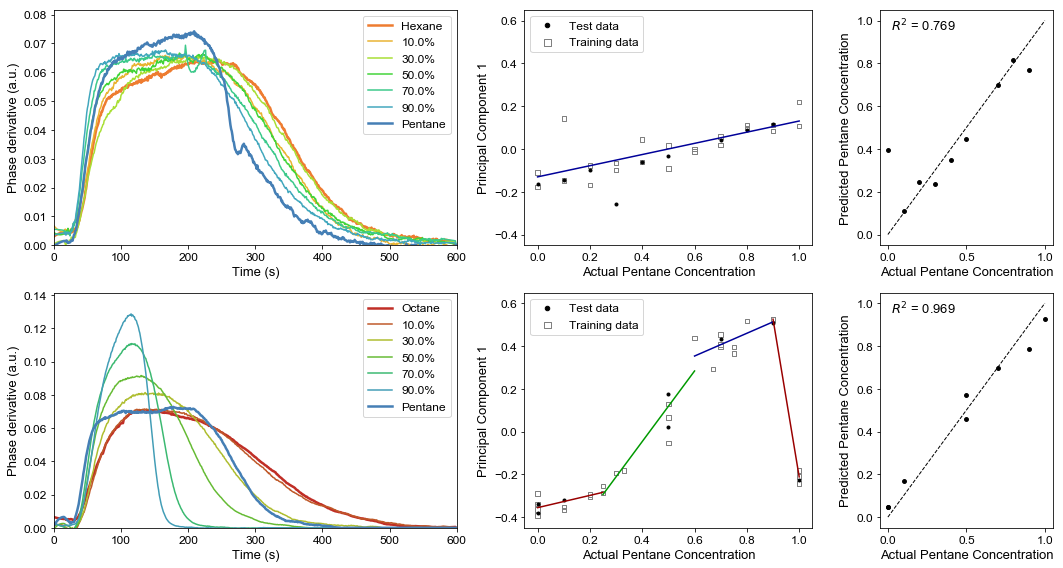

In [76]:
from matplotlib import gridspec
widths = [7, 5, 3] #, 3]
heights = [4, 4]
fig, ax = plt.subplots(nrows=len(heights), ncols=len(widths), sharex=False, sharey=False, gridspec_kw={'height_ratios': heights, 'width_ratios': widths}, figsize=(sum(widths),sum(heights)));
#gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

# divide figure into suplots
axB = ax[0,:] #[fig.add_subplot(gs[0, c]) for c in range(0,4)]
axC = ax[1,:] #[fig.add_subplot(gs[-1, c]) for c in range(0,4)]

# add phase derivative plots
plot_derivs(C5C6_derivs, C5C6_concentrations, c2='Hexane', c1 = 'Pentane', ax = axB[0])
plot_derivs(C5C8_derivs, C5C8_concentrations, c2='Octane', c1 = 'Pentane', ax = axC[0])

# add SVR regression plots
plot_regression(C5C6_test_lbl, SVR['C5C6'].predict(C5C6_test), c=color['test'], ax = axB[2])
plot_regression(C5C8_test_lbl, SVR['C5C8'].predict(C5C8_test), c=color['test'], ax = axC[2])

# add segmentation results
plot_segmentation(model['C5C6'], C5C6_train, C5C6_train_lbl, C5C6_test, C5C6_test_lbl, initial_colorID = 2, ax = axB[1])
plot_segmentation(model['C5C8'], C5C8_train, C5C8_train_lbl, C5C8_test, C5C8_test_lbl, initial_colorID = 0, ax = axC[1])

# add SVR regression plots with segmentation
#plot_regression(C5C6_test_lbl, predict_multiSVR(model['C5C6'], C5C6_test), c='k', model = model['C5C6'], initial_colorID = 2, ax = axB[3])
#plot_regression(C5C8_test_lbl, predict_multiSVR(model['C5C8'], C5C8_test), c='k', model = model['C5C8'], initial_colorID = 0, ax = axC[3])

# Remove xlabels in the first row and space out labels
#for n in range(0,len(widths)):
#    ax[0,n].set_xlabel('')
plt.tight_layout()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Figure-4 JN.svg', format='svg', dpi=1200)

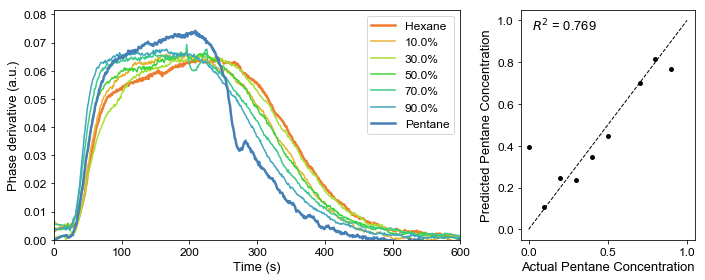

In [19]:
widths = [7, 3] #, 3]
heights = [4]
fig, ax = plt.subplots(nrows=len(heights), ncols=len(widths), sharex=False, sharey=False, gridspec_kw={'height_ratios': heights, 'width_ratios': widths}, figsize=(sum(widths),sum(heights)));

#plot_derivs(C5C8_derivs, C5C8_concentrations, c2='Octane', c1 = 'Pentane', ax = ax[0])
#plot_regression(C5C8_test_lbl, SVR['C5C8'].predict(C5C8_test), c=color['test'], ax = ax[1])
plot_derivs(C5C6_derivs, C5C6_concentrations, c2='Hexane', c1 = 'Pentane', ax = ax[0])
plot_regression(C5C6_test_lbl, SVR['C5C6'].predict(C5C6_test), c=color['test'], ax = ax[1])
plt.tight_layout()
fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Pentane-Hexane mixtures.svg', format='svg', dpi=1200)

## Supplementary figures

#### Functions

In [77]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_std = []
    test_mean = []
    test_std = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size,random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                estimator.fit(derivs, lbls);
                score = estimator.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(estimator.score(derivs, lbls))
                    test_score.append(estimator.score(test_derivs, test_lbl))
            else: # train multi-region SVR
                model = train_multiSVR(derivs, lbls, kernel=kernel, error_thresh = 0.07);
                score = calculate_R2(test_lbl,predict_multiSVR(model, test_derivs))
    
                if score > 0:
                    train_score.append(calculate_R2(lbls,predict_multiSVR(model, derivs)))
                    test_score.append(calculate_R2(test_lbl,predict_multiSVR(model, test_derivs)))

        train_mean.append(np.mean(train_score, axis=0))
        train_std.append(np.std(train_score, axis=0))
        test_mean.append(np.mean(test_score, axis=0))
        test_std.append(np.std(test_score, axis=0))

    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="bottom right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(train_std[-1]) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(test_std[-1]) + ")")
    
    return test_mean, test_std, M

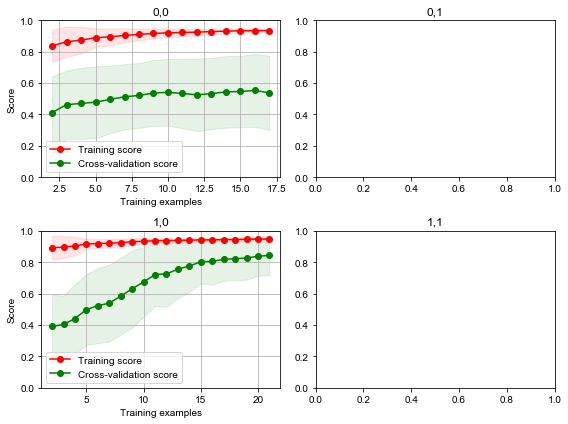

In [78]:
from IPython.utils import io

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))

avgN = 100

with io.capture_output() as captured:
    plot_learning_curve(SVR['C5C6'], C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,0]);
    #plot_learning_curve('multi', C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,1]);
    plot_learning_curve(SVR['C5C8'], C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,0]);
    #plot_learning_curve('multi', C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,1]);
    
ax[0,0].set_title('0,0')
ax[0,1].set_title('0,1')
ax[1,0].set_title('1,0')
ax[1,1].set_title('1,1')
fig.tight_layout()

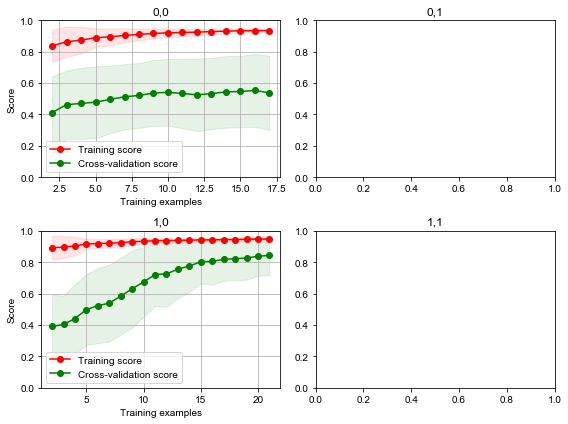

In [79]:
from IPython.utils import io

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))

avgN = 100

with io.capture_output() as captured:
    plot_learning_curve(SVR['C5C6'], C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,0]);
    #plot_learning_curve('multi', C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,1]);
    plot_learning_curve(SVR['C5C8'], C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,0]);
    #plot_learning_curve('multi', C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,1]);
    
ax[0,0].set_title('0,0')
ax[0,1].set_title('0,1')
ax[1,0].set_title('1,0')
ax[1,1].set_title('1,1')
fig.tight_layout()

In [80]:
from sklearn.model_selection import train_test_split

def plot_learning_points(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_dist = []
    train_m = []
    test_mean = []
    test_dist = []
    test_m = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size,random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                SVR = train_SVR(derivs, lbls, kernel=kernel);
                score = SVR.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(SVR.score(derivs, lbls))
                    test_score.append(SVR.score(test_derivs, test_lbl))
            else: # train multi-region SVR
                model = train_multiSVR(derivs, lbls, kernel=kernel, error_thresh = 0.07);
                score = calculate_R2(test_lbl,predict_multiSVR(model, test_derivs))
    
                if score > 0:
                    train_score.append(calculate_R2(lbls,predict_multiSVR(model, derivs)))
                    test_score.append(calculate_R2(test_lbl,predict_multiSVR(model, test_derivs)))

        train_mean.append(np.mean(train_score, axis=0))
        train_dist.append(train_score)
        train_m.append([m for score in train_score])
        test_mean.append(np.mean(test_score, axis=0))
        test_dist.append(test_score)
        test_m.append([m for score in test_score])

    flatten = lambda l: [item for sublist in l for item in sublist]
    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.scatter(flatten(train_m), flatten(train_dist), alpha=0.1,color="r")
    ax.scatter(flatten(test_m), flatten(test_dist), alpha=0.1,color="g")
    #ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    #ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="bottom right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(np.std(train_score, axis=0)) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(np.std(test_score, axis=0)) + ")")
    
    return test_mean[-1], np.std(test_score, axis=0) #, np.max(test_score, axis=0), M

Max of C5C6: 0.53 ± 0.243
Max of C5C8: 0.845 ± 0.125


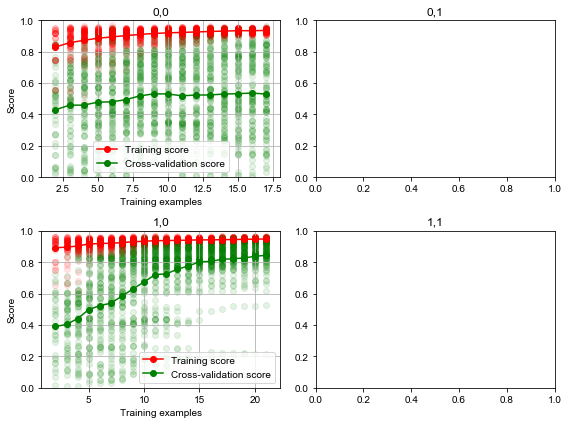

In [81]:
from IPython.utils import io

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))

avgN = 100

with io.capture_output() as captured:
    m6, s6 = plot_learning_points('single', C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,0]);
    #plot_learning_points('multi', C5C6_derivs.values(), C5C6_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0,1]);
    m8, s8 = plot_learning_points('single', C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,0]);
    #plot_learning_points('multi', C5C8_derivs.values(), C5C8_concentrations.values(), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1,1]);
    
ax[0,0].set_title('0,0')
ax[0,1].set_title('0,1')
ax[1,0].set_title('1,0')
ax[1,1].set_title('1,1')
fig.tight_layout()

print "Max of C5C6: " + str(m6.round(3)) + " ± " + str(s6.round(3))
print "Max of C5C8: " + str(m8.round(3)) + " ± " + str(s8.round(3))

##### Feature weight comparison

In [82]:
linSVR = {}
kernel = 'linear'

# train simple SVR
print 'Hexane'
linSVR['C5C6'] = train_SVR(C5C6_train, C5C6_train_lbl, kernel=kernel, C=26.6)
print 'Testing accuracy: ' + str( linSVR['C5C6'].score(C5C6_test, C5C6_test_lbl) )

print '\nOctane'
linSVR['C5C8'] = train_SVR(C5C8_train, C5C8_train_lbl, kernel=kernel, C=200)
print 'Testing accuracy: ' + str( linSVR['C5C8'].score(C5C8_test, C5C8_test_lbl) )

Hexane
Training accuracy: 0.757211102611 (22)
Testing accuracy: 0.784978249384

Octane
Training accuracy: 0.940941150011 (29)
Testing accuracy: 0.894525639004


In [83]:
all_derivs = dict([('C5C6',C5C6_derivs),('C5C8',C5C8_derivs)])
all_set = dict([('C5C6',C5C6_set),('C5C8',C5C8_set)])

In [84]:
def plot_array_data(exp_set, input_data, xlim, ylim=None, color_dict = None, legend=True, ax=None, linewidth = None, linestyle = '-', label = True):
    if ax == None:
        fig, ax = plt.subplots()
        
    for chem in exp_set:    
        nums = exp_set[chem]
        data = [input_data[n] for n in nums]

        # calculate average
        avg = np.average(data, axis = 0)
        std = np.std(data, axis = 0)
        
        try:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, linestyle = linestyle, linewidth = linewidth, color = color_dict[chem])
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), color = color_dict[chem], alpha=0.1)
        except:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, color = None)
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), alpha=0.1)
        if legend:
            if len(exp_set) > 8:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=legendsize)
            else:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=1, frameon=False, shadow=False, fontsize=legendsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if label == True:
        if xlim[0] == 0:
            ax.set_xlabel("Time (s)", fontsize=labelsize);
            ax.set_ylabel("Phase derivative (a.u.)", fontsize=labelsize)
        else:
            ax.set_xlabel("Wavelength (nm)", fontsize=labelsize)
            ax.set_ylabel("$\Delta I$ (a.u.)", fontsize=labelsize)
        ax.tick_params(labelsize=ticksize)
    else:
        ax.set_xticks = []

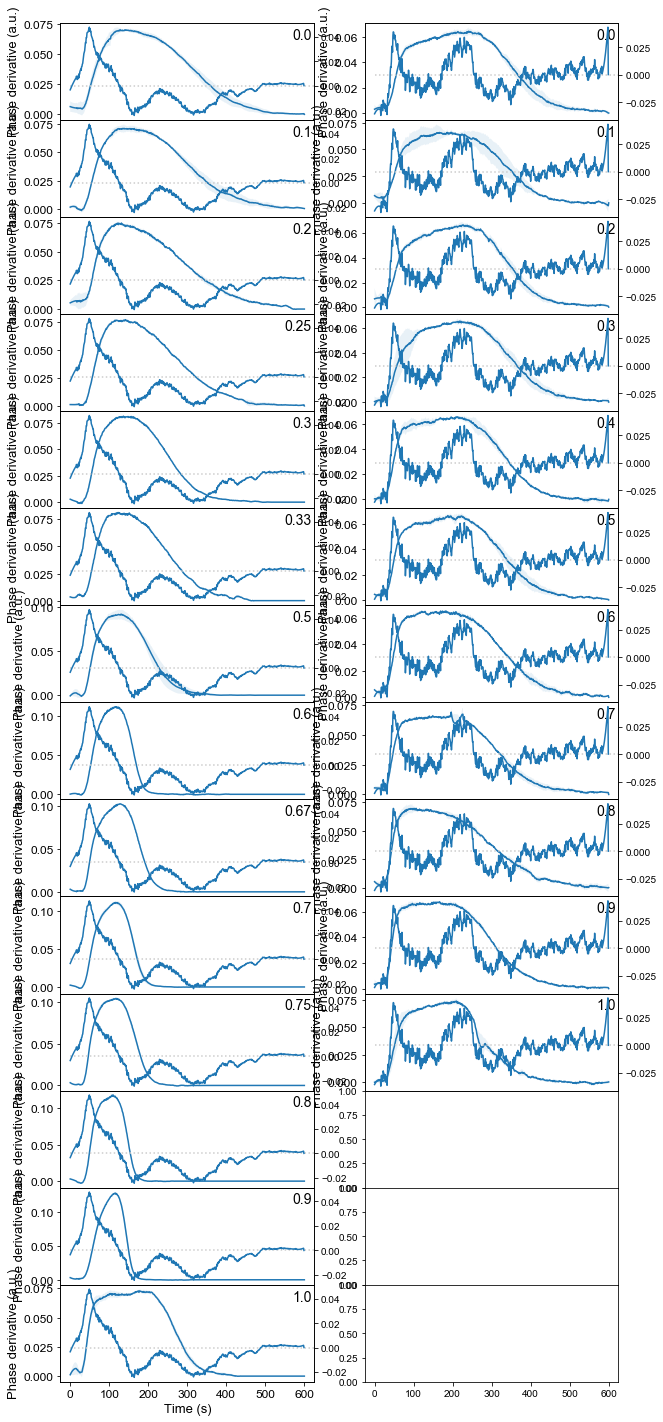

In [85]:
fig,ax = plt.subplots(ncols = len(SVR), nrows = len(all_set['C5C8']), sharex = True)
fig.set_figheight(25)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=0)

for m,mixture in enumerate(SVR.keys()):
    for n,chem in enumerate(all_set[mixture]):
        subset = OrderedDict([all_set[mixture].items()[n]])
        plot_array_data(subset, all_derivs[mixture], [0,600], ylim=None, color_dict = color_dict, ax=ax[n,m], linestyle = ':', linewidth = 1.5)
        ax[n,m].get_legend().remove()

        ax2 = ax[n,m].twinx()
        #ax2.set_ylim([-250,250])
        ax2.set_xlim([-25,625])
        ax2.plot([0,650],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        ax2.plot((np.dot(SVR[mixture].dual_coef_,SVR[mixture].support_vectors_)).T)
        #ax2.plot(SVR[mixture].coef_[0], color=color_dict[chem])
        ax[n,m].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n,m].transAxes)

In [86]:
from sklearn.gaussian_process.kernels import RBF
rbf = RBF(np.sqrt(1./2/SVR[mixture].gamma)) #0.267)#SVR[mixture].gamma)

np.dot(SVR[mixture].dual_coef_, rbf(all_derivs[mixture][174].reshape(1,-1),SVR[mixture].support_vectors_).T)+SVR[mixture].intercept_

KeyError: 174

In [ ]:
mixture = 'C5C8'

# plot multiplied feature coef_ and average phase derivative
fig,ax = plt.subplots(ncols = 1, nrows = len(all_set[mixture]), sharex = True)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0)

for n,chem in enumerate(all_set[mixture]):
    subset = OrderedDict([all_set[mixture].items()[n]])
    data = [all_derivs[mixture][m] for m in subset.values()[0]]
    avg = np.average(data, axis = 0) # calculate average

    ax[n].set_xlim([-25,625])
    ax[n].plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
    ax[n].plot((np.dot(SVR[mixture].dual_coef_,SVR[mixture].support_vectors_)*avg).T)
    #ax[n].plot(SVR[mixutre].coef_[0]*avg, color=color_dict[chem])
    ax[n].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n].transAxes)
    ax[n].set_ylim([-0.002,0.003])

In [ ]:
plot_regression(C5C8_test_lbl, linSVR['C5C8'].predict(C5C8_test), c=color['test'])

## Similarity plots

In [87]:
import numpy as np
import similaritymeasures
import matplotlib.pyplot as plt

Pentane-Octane

In [88]:
sim = np.zeros((len(C5C8_set),len(C5C8_set)))
normalize = lambda x: x/np.sqrt(np.dot(x,x))

for n,chem in enumerate(C5C8_set):
    data = [C5C8_derivs[ind] for ind in C5C8_set[chem]]
    avg = np.average(data, axis = 0) # calculate average
    avg = normalize(avg)
    
    data_n = np.zeros((600,2))
    data_n[:,0] = avg
    data_n[:,1] = np.linspace(0,600,600)
    
    for m,chem in enumerate(C5C8_set):
        data2 = [C5C8_derivs[ind] for ind in C5C8_set[chem]]
        avg2 = np.average(data2, axis = 0) # calculate average
        avg2 = normalize(avg2)
        
        data_m = np.zeros((600,2))
        data_m[:,0] = avg2
        data_m[:,1] = np.linspace(0,600,600)
    
        sim[n,m] = round(similaritymeasures.area_between_two_curves(data_n, data_m),3)

In [89]:
table = []
for n,chem in enumerate(C5C8_set):
    row = [chem]
    for m in range(sim.shape[1]):
        row.append(sim[n,m])
    
    table.append(row)
    
from tabulate import tabulate
print(tabulate(table, headers=C5C8_set.keys()))

         0.0     0.1     0.2    0.25     0.3    0.33    0.5     0.6    0.67     0.7    0.75     0.8     0.9     1.0
----  ------  ------  ------  ------  ------  ------  -----  ------  ------  ------  ------  ------  ------  ------
0      0       0.916   1.474   2.706   5.425   4.976  9.617  14.757  12.864  14.614  14.034  16.407  16.33    5.242
0.1    0.916   0       1.383   2.141   4.886   4.734  9.314  14.525  12.653  14.387  13.881  16.174  16.206   5.135
0.2    1.474   1.383   0       1.94    4.677   4.191  8.888  14.077  12.146  13.935  13.344  15.779  15.7     5.04
0.25   2.706   2.142   1.941   0       2.903   2.67   7.27   12.651  10.662  12.535  11.963  14.456  14.42    4.108
0.3    5.425   4.886   4.677   2.903   0       0.991  4.72   10.29    8.191  10.134   9.602  12.166  12.179   2.569
0.33   4.975   4.734   4.191   2.67    0.991   0      4.863  10.385   8.283  10.238   9.639  12.263  12.183   2.871
0.5    9.617   9.314   8.888   7.27    4.72    4.863  0       5.767   3.5

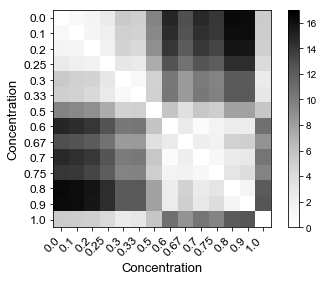

In [97]:
vmax = np.ceil(np.max(sim))

fig, ax = plt.subplots()
i = ax.imshow(sim, cmap=plt.cm.Greys, interpolation='nearest',vmin=0, vmax=vmax)
fig.colorbar(i)

ax.set_xticks(range(0,len(C5C8_set)))
ax.set_xticklabels(C5C8_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize);
ax.set_yticks(range(0,len(C5C8_set)))
ax.set_yticklabels(C5C8_set.keys(), horizontalalignment='right', fontsize=ticksize);
ax.set_xlabel('Concentration', fontsize = labelsize)
ax.set_ylabel('Concentration', fontsize = labelsize)

plt.show()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5C8 similarity.svg', format='svg', dpi=1200)

Pentane-Hexane

In [91]:
sim2 = np.zeros((len(C5C6_set),len(C5C6_set)))
normalize = lambda x: x/np.sqrt(np.dot(x,x))

for n,chem in enumerate(C5C6_set):
    data = [C5C6_derivs[ind] for ind in C5C6_set[chem]]
    avg = np.average(data, axis = 0) # calculate average
    avg = normalize(avg)
    
    data_n = np.zeros((600,2))
    data_n[:,0] = avg
    data_n[:,1] = np.linspace(0,600,600)
    
    for m,chem in enumerate(C5C6_set):
        data2 = [C5C6_derivs[ind] for ind in C5C6_set[chem]]
        avg2 = np.average(data2, axis = 0) # calculate average
        avg2 = normalize(avg2)
        
        data_m = np.zeros((600,2))
        data_m[:,0] = avg2
        data_m[:,1] = np.linspace(0,600,600)
    
        sim2[n,m] = round(similaritymeasures.area_between_two_curves(data_n, data_m),3)

In [92]:
table = []
for n,chem in enumerate(C5C6_set):
    row = [chem]
    for m in range(sim2.shape[1]):
        row.append(sim2[n,m])
    
    table.append(row)
    
from tabulate import tabulate
print(tabulate(table, headers=C5C6_set.keys()))

       0.0    0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    1.0
---  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
0    0      2.418  1.302  0.901  2.931  2.38   2.85   3.76   4.87   4.979  6.605
0.1  2.417  0      1.492  2.292  0.981  0.957  1.374  2.043  3.191  2.858  4.373
0.2  1.302  1.494  0      1.175  2.029  1.6    2.259  3.015  4.264  4.137  5.611
0.3  0.902  2.294  1.175  0      2.625  2.244  2.81   3.694  4.79   4.864  6.222
0.4  2.93   0.982  2.028  2.624  0      0.793  1.29   1.81   2.914  2.559  3.756
0.5  2.38   0.958  1.6    2.243  0.793  0      0.896  1.617  2.805  2.735  4.323
0.6  2.851  1.376  2.259  2.81   1.291  0.896  0      1.159  2.168  2.222  4.214
0.7  3.761  2.045  3.015  3.694  1.812  1.618  1.159  0      1.583  1.455  3.697
0.8  4.87   3.192  4.264  4.789  2.915  2.804  2.167  1.582  0      1.314  3.766
0.9  4.979  2.86   4.137  4.864  2.56   2.735  2.222  1.455  1.315  0      2.878
1    6.605  4.375  5.61   6.

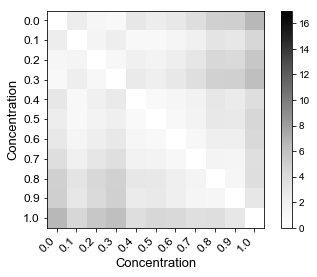

In [96]:
fig, ax = plt.subplots()
i = ax.imshow(sim2, cmap=plt.cm.Greys, interpolation='nearest',vmin=0, vmax=vmax)
fig.colorbar(i)

ax.set_xticks(range(0,len(C5C6_set)))
ax.set_xticklabels(C5C6_set.keys(), rotation=45, horizontalalignment='right', fontsize=ticksize);
ax.set_yticks(range(0,len(C5C6_set)))
ax.set_yticklabels(C5C6_set.keys(), horizontalalignment='right', fontsize=ticksize);

ax.set_xlabel('Concentration', fontsize = labelsize)
ax.set_ylabel('Concentration', fontsize = labelsize)

plt.show()
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5C6 similarity.svg', format='svg', dpi=1200)